# Positional accuracy of a 6-axis Robot Arm

<div style="width: 500px;">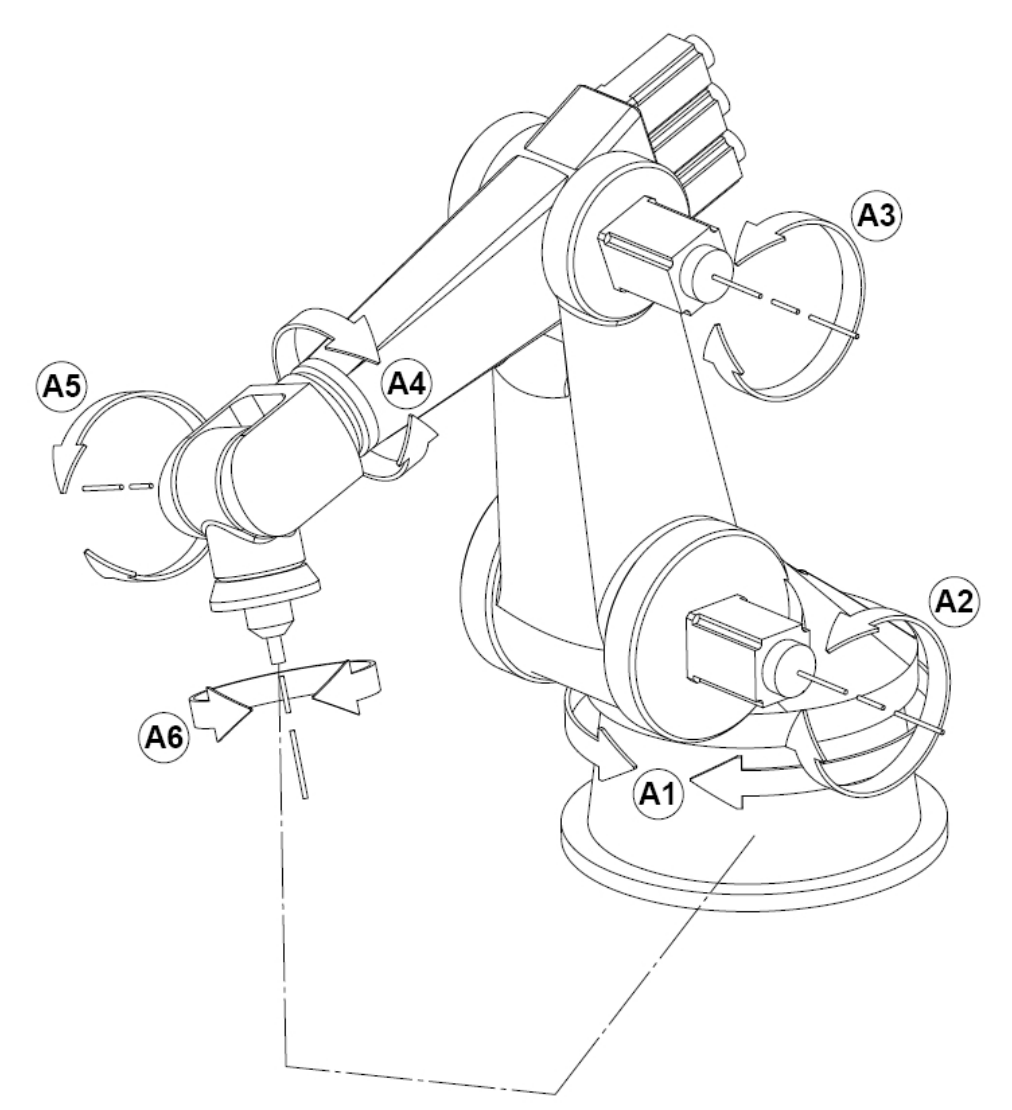</div>

For this project I'm working with a dataset of positional measurements for a 6-axis robot arm with end-effector. The robot was commanded to assume 199 unique poses, with each pose defined by the six joint positions. At each pose, three points on the end effector (structure mounted beyond joint 6) were measured in Cartesian space. 

Each row of the dataset represents the robot in a single, unique pose, and there is data for 199 poses. For each pose, we have 
* **columns 1-6, (A1, A2, A3, A4, A5, A6), the joint angles the robot was commanded to** - angles that the robot was commanded to drive each axis to, in degrees. The angles "A1" through "A6" correspond to the angles "A1" through "A6" in the cartoon image above above.
* **columns 7-15, (XA, YA, ZA), the *actual/measured* location of the end effector** - (x, y, z) coordinates (in mm) of each of the three points on the end effector (sufficient to determine not just location but also orientation of robot's toolpoint)
* **columns 16-24, (XN, YN, ZN), the *nominal/expected* location of the end effector** - expected (x, y, z) coordinates (in mm) of the same three points were calculated  by feeding the joint positions to a forward kinematics model configured with nominal values for this robot (though not calibrated for this particular robot nor compensated for it's installation (that's actually the purpose the data was captured for!))
* **columns 25-36, (dx, dy, dz, err), the error in the kinematic model's prediction**  - (dx, dy, dz) are the coordinates (in mm) of the resultant vector if you subtract the nominal/expected position from the actual/measured position (i.e. the 3D error in the model), and "err" is the magnitude of that vector.

All measurements were made using a high precision laser position tracker, returning the coordinates of these points in a Cartesian coordinate system to a 3-sigma accuracy of +/- 0.025 mm (i.e. 99.7% of measurements are within 0.025 mm of the true value). 

The coordinate frame is aligned such that:
* X+ points in the direction of A1 = 0.
* Y+ is vertical, aligned to gravity; note that the robot is mounted on an imperfect surface, so this is not perfectly coincident with the vector of the A1 axis.
* Z+ is determined by the right-hand-rule
* The origin is defined as being coincident with the bottom surface of the base beneath the A1 joint, and coincident with the vector of the A1 axis.

In [29]:
# import libraries and set defaults
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', 40)
pd.set_option('precision',3)
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

In [28]:
# load robodata.csv into dataframe
robodata = pd.read_csv('robodata.csv')
robodata.head()

,A1,A2,A3,A4,A5,A6,xa1,ya1,za1,xa2,ya2,za2,xa3,ya3,za3,xn1,yn1,zn1,xn2,yn2,zn2,xn3,yn3,zn3,dx1,dy1,dz1,err1,dx2,dy2,dz2,err2,dx3,dy3,dz3,err3
0,25.3,-69.4,90.1,-175.0,10.6,22.1,3569.589,1667.628,1664.441,3280.233,1689.938,1807.605,3468.103,1923.943,1495.405,3569.535,1667.530,1664.575,3280.189,1689.935,1807.710,3468.090,1923.822,1495.450,0.054,0.098,-0.134,0.175,0.045,0.003,-0.104,0.114,0.013,0.121,-0.045,0.130
1,18.3,-90.9,57.1,-174.1,-68.7,67.3,2782.271,2678.499,1055.741,2640.343,2935.808,1191.244,2768.137,2855.376,785.392,2782.430,2678.874,1055.892,2640.516,2936.218,1191.336,2768.246,2855.677,785.487,-0.158,-0.375,-0.151,0.434,-0.173,-0.410,-0.092,0.455,-0.109,-0.301,-0.095,0.334
2,16.1,-111.7,96.6,-171.9,-42.7,145.1,2655.783,2264.947,900.780,2628.147,2543.976,739.257,2433.991,2160.061,690.104,2655.858,2265.032,900.872,2628.253,2544.055,739.333,2434.038,2160.148,690.220,-0.075,-0.085,-0.093,0.146,-0.106,-0.080,-0.077,0.153,-0.047,-0.087,-0.116,0.153
3,23.6,-97.2,52.8,-170.8,-71.2,82.5,2405.550,3060.262,1273.083,2262.407,3344.750,1330.362,2389.892,3152.920,963.656,2405.628,3060.496,1273.170,2262.474,3345.000,1330.402,2389.934,3153.116,963.728,-0.079,-0.234,-0.087,0.262,-0.067,-0.250,-0.040,0.262,-0.042,-0.196,-0.072,0.213
4,25.3,-66.9,96.0,-170.6,23.1,100.8,3576.144,1517.902,1596.277,3394.300,1784.808,1576.172,3465.213,1460.642,1297.949,3576.139,1517.828,1596.307,3394.316,1784.748,1576.166,3465.193,1460.531,1298.000,0.005,0.074,-0.030,0.080,-0.016,0.060,0.006,0.062,0.020,0.111,-0.050,0.124


In [21]:
robodata.shape

(199, 36)

In [23]:
robodata.describe()

,J1,J2,J3,J4,J5,J6,xa1,ya1,za1,xa2,ya2,za2,xa3,ya3,za3,xn1,yn1,zn1,xn2,yn2,zn2,xn3,yn3,zn3,dx1,dy1,dz1,err1,dx2,dy2,dz2,err2,dx3,dy3,dz3,err3
count,199.000,199.000,199.000,199.000,199.000,199.000,199.000,199.000,199.000,199.000,199.000,199.000,199.000,199.000,199.000,199.000,199.000,199.000,199.000,199.000,199.000,199.000,199.000,199.000,1.990e+02,1.990e+02,199.000,199.000,199.000,199.000,199.000,199.000,199.000,199.000,199.000,199.000
mean,23.768,-79.033,80.067,4.226,-0.501,165.310,2781.660,1978.804,1271.983,2615.590,2160.558,1261.650,2689.204,2021.012,1055.019,2781.663,1978.807,1271.984,2615.598,2160.548,1261.646,2689.207,2021.014,1055.021,-3.422e-03,-2.500e-03,-0.001,0.154,-0.008,0.010,0.003,0.157,-0.003,-0.002,-0.001,0.154
std,33.497,32.507,31.795,103.877,62.929,98.473,739.376,690.224,816.225,736.573,712.233,883.140,789.155,744.179,840.629,739.357,690.223,816.213,736.576,712.228,883.140,789.149,744.172,840.618,9.508e-02,1.066e-01,0.096,0.075,0.096,0.115,0.092,0.081,0.094,0.109,0.095,0.076
min,-45.000,-129.000,10.000,-175.000,-100.000,0.000,1249.021,490.556,-665.440,1068.988,489.066,-917.488,999.905,290.948,-968.552,1249.114,490.421,-665.502,1068.803,489.017,-917.501,1000.006,291.022,-968.573,-2.652e-01,-3.746e-01,-0.322,0.032,-0.267,-0.410,-0.260,0.024,-0.370,-0.301,-0.289,0.040
25%,-4.000,-105.900,56.350,-87.300,-66.350,84.400,2252.928,1498.596,724.479,2113.314,1650.103,627.053,2088.453,1538.307,477.714,2253.049,1498.644,724.515,2113.335,1650.082,626.976,2088.481,1538.374,477.744,-6.450e-02,-6.307e-02,-0.066,0.101,-0.068,-0.058,-0.061,0.099,-0.058,-0.077,-0.063,0.092
50%,24.300,-82.400,86.200,13.900,9.700,161.800,2703.066,1883.070,1353.896,2563.854,2118.960,1284.311,2621.814,1974.704,1143.295,2703.161,1882.955,1353.754,2564.058,2118.882,1284.288,2621.688,1974.610,1143.240,1.297e-04,-7.151e-05,-0.005,0.144,-0.015,0.014,0.001,0.140,0.004,-0.010,0.002,0.138
75%,50.450,-59.950,107.150,98.200,61.250,227.550,3365.697,2461.316,1925.056,3193.724,2631.866,1956.620,3250.262,2594.306,1718.306,3365.665,2461.388,1925.086,3193.634,2631.963,1956.709,3250.232,2594.377,1718.238,5.506e-02,6.076e-02,0.061,0.195,0.047,0.075,0.059,0.205,0.055,0.066,0.055,0.189
max,90.000,16.300,125.000,175.000,100.000,359.000,4292.948,3526.632,2901.797,4158.293,3686.011,3064.844,4318.107,3741.343,2656.582,4292.996,3526.580,2901.537,4158.363,3685.891,3064.661,4318.180,3741.236,2656.357,2.866e-01,2.745e-01,0.331,0.441,0.273,0.443,0.273,0.552,0.260,0.301,0.288,0.398


In [54]:
# make dataframe containing just the joint positions for each pose
joint_cols = robodata.iloc[:, 0:6].columns
joints = robodata[joint_cols]
joints.describe()

,A1,A2,A3,A4,A5,A6
count,199.000,199.000,199.000,199.000,199.000,199.000
mean,23.768,-79.033,80.067,4.226,-0.501,165.310
std,33.497,32.507,31.795,103.877,62.929,98.473
min,-45.000,-129.000,10.000,-175.000,-100.000,0.000
25%,-4.000,-105.900,56.350,-87.300,-66.350,84.400
50%,24.300,-82.400,86.200,13.900,9.700,161.800
75%,50.450,-59.950,107.150,98.200,61.250,227.550
max,90.000,16.300,125.000,175.000,100.000,359.000


In [55]:
# make dataframe containing just the measured positions for each pose
actuals_cols = robodata.iloc[:, 6:15].columns
actuals = robodata[actuals_cols]
actuals.describe()

,xa1,ya1,za1,xa2,ya2,za2,xa3,ya3,za3
count,199.000,199.000,199.000,199.000,199.000,199.000,199.000,199.000,199.000
mean,2781.660,1978.804,1271.983,2615.590,2160.558,1261.650,2689.204,2021.012,1055.019
std,739.376,690.224,816.225,736.573,712.233,883.140,789.155,744.179,840.629
min,1249.021,490.556,-665.440,1068.988,489.066,-917.488,999.905,290.948,-968.552
25%,2252.928,1498.596,724.479,2113.314,1650.103,627.053,2088.453,1538.307,477.714
50%,2703.066,1883.070,1353.896,2563.854,2118.960,1284.311,2621.814,1974.704,1143.295
75%,3365.697,2461.316,1925.056,3193.724,2631.866,1956.620,3250.262,2594.306,1718.306
max,4292.948,3526.632,2901.797,4158.293,3686.011,3064.844,4318.107,3741.343,2656.582


In [56]:
# make dataframe containing just the nominal positions for each pose
nominals_cols = robodata.iloc[:, 15:24].columns
nominals = robodata[nominals_cols]
nominals.describe()

,xn1,yn1,zn1,xn2,yn2,zn2,xn3,yn3,zn3
count,199.000,199.000,199.000,199.000,199.000,199.000,199.000,199.000,199.000
mean,2781.663,1978.807,1271.984,2615.598,2160.548,1261.646,2689.207,2021.014,1055.021
std,739.357,690.223,816.213,736.576,712.228,883.140,789.149,744.172,840.618
min,1249.114,490.421,-665.502,1068.803,489.017,-917.501,1000.006,291.022,-968.573
25%,2253.049,1498.644,724.515,2113.335,1650.082,626.976,2088.481,1538.374,477.744
50%,2703.161,1882.955,1353.754,2564.058,2118.882,1284.288,2621.688,1974.610,1143.240
75%,3365.665,2461.388,1925.086,3193.634,2631.963,1956.709,3250.232,2594.377,1718.238
max,4292.996,3526.580,2901.537,4158.363,3685.891,3064.661,4318.180,3741.236,2656.357


In [57]:
# make dataframe containing just the errors of the positions for each pose
error_cols = robodata.iloc[:, 24:].columns
errors = robodata[error_cols]
errors.describe()

,dx1,dy1,dz1,err1,dx2,dy2,dz2,err2,dx3,dy3,dz3,err3
count,1.990e+02,1.990e+02,199.000,199.000,199.000,199.000,199.000,199.000,199.000,199.000,199.000,199.000
mean,-3.422e-03,-2.500e-03,-0.001,0.154,-0.008,0.010,0.003,0.157,-0.003,-0.002,-0.001,0.154
std,9.508e-02,1.066e-01,0.096,0.075,0.096,0.115,0.092,0.081,0.094,0.109,0.095,0.076
min,-2.652e-01,-3.746e-01,-0.322,0.032,-0.267,-0.410,-0.260,0.024,-0.370,-0.301,-0.289,0.040
25%,-6.450e-02,-6.307e-02,-0.066,0.101,-0.068,-0.058,-0.061,0.099,-0.058,-0.077,-0.063,0.092
50%,1.297e-04,-7.151e-05,-0.005,0.144,-0.015,0.014,0.001,0.140,0.004,-0.010,0.002,0.138
75%,5.506e-02,6.076e-02,0.061,0.195,0.047,0.075,0.059,0.205,0.055,0.066,0.055,0.189
max,2.866e-01,2.745e-01,0.331,0.441,0.273,0.443,0.273,0.552,0.260,0.301,0.288,0.398


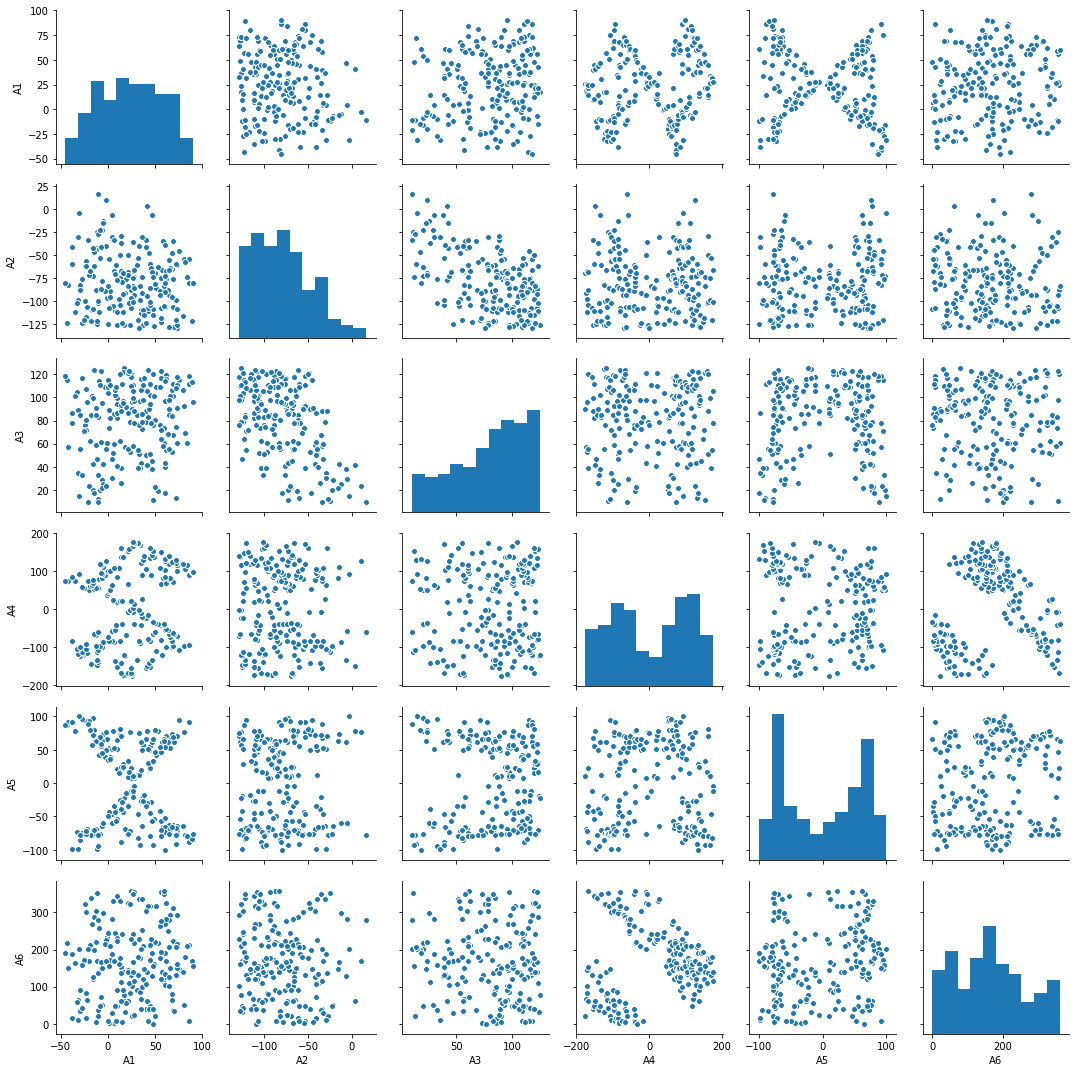

In [61]:
sns.pairplot(joints)